In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

# ----------------------------
# SETTINGS
# ----------------------------
OUT_DIR = "/content/scratch_samples"
os.makedirs(OUT_DIR, exist_ok=True)

N_SAMPLES = 10

# NEW: stricter scratch threshold + compact labels
MIN_ADJ_NONWHITE_PIXELS = 100   # scratch iff connected component has >100 pixels (adjacent)
LABEL_MAP = {"vertical": "v", "horizontal": "h", "diagonal/other": "d", "no scratch": "none"}

# Crop after resizing (same pipeline)
crop_top = 20
crop_bottom = 20
crop_left = 20
crop_right = 20

# Synthetic image settings
IMG_W, IMG_H = 1024, 768
N_RANDOM_DEFECTS_RANGE = (200, 700)
CIRCLE_RADIUS_RANGE = (2, 3)

# Make scratches thick/long enough to exceed 100 pixels
SCRATCH_LEN_RANGE = (35, 70)  # longer chain
SCRATCH_STEP = 5              # slightly denser
SCRATCH_THICKNESS_JITTER = 1

DEFECT_COLORS = [
    (0, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
    (0, 128, 255),
    (0, 180, 0),
    (128, 0, 128),
    (42, 42, 165),
]

# ----------------------------
# SYNTHETIC IMAGE GENERATION
# ----------------------------
def draw_random_defects(img, n_defects):
    h, w = img.shape[:2]
    for _ in range(n_defects):
        x = random.randint(10, w - 10)
        y = random.randint(10, h - 10)
        r = random.randint(*CIRCLE_RADIUS_RANGE)
        color = random.choice(DEFECT_COLORS)
        cv2.circle(img, (x, y), r, color, thickness=-1)

def draw_scratch(img, segment="left", orientation="vertical"):
    h, w = img.shape[:2]
    seg_w = w // 3

    if segment == "left":
        x_min, x_max = 10, seg_w - 10
    elif segment == "center":
        x_min, x_max = seg_w + 10, 2 * seg_w - 10
    else:
        x_min, x_max = 2 * seg_w + 10, w - 10

    length = random.randint(*SCRATCH_LEN_RANGE)
    color = random.choice(DEFECT_COLORS)
    r = random.randint(*CIRCLE_RADIUS_RANGE)

    x0 = random.randint(x_min, x_max)
    y0 = random.randint(10, h - 10)

    if orientation == "vertical":
        dx, dy = 0, SCRATCH_STEP
    elif orientation == "horizontal":
        dx, dy = SCRATCH_STEP, 0
    else:
        dx, dy = SCRATCH_STEP, SCRATCH_STEP

    x, y = x0, y0
    for _ in range(length):
        jx = random.randint(-SCRATCH_THICKNESS_JITTER, SCRATCH_THICKNESS_JITTER)
        jy = random.randint(-SCRATCH_THICKNESS_JITTER, SCRATCH_THICKNESS_JITTER)
        xx = int(np.clip(x + jx, 2, w - 3))
        yy = int(np.clip(y + jy, 2, h - 3))
        cv2.circle(img, (xx, yy), r, color, thickness=-1)
        x += dx
        y += dy
        if x < 5 or x > w - 5 or y < 5 or y > h - 5:
            break

def make_one_sample(idx):
    img = np.full((IMG_H, IMG_W, 3), 255, dtype=np.uint8)
    draw_random_defects(img, random.randint(*N_RANDOM_DEFECTS_RANGE))

    gt = {"left": "none", "center": "none", "right": "none"}
    for seg in ["left", "center", "right"]:
        if random.random() < 0.6:
            ori = random.choice(["vertical", "horizontal", "diagonal/other"])
            draw_ori = "diagonal" if ori == "diagonal/other" else ori
            draw_scratch(img, segment=seg, orientation=draw_ori)
            gt[seg] = LABEL_MAP[ori]

    fname = f"sample_{idx:02d}.png"
    fpath = os.path.join(OUT_DIR, fname)
    cv2.imwrite(fpath, img)
    return fpath, gt

# ----------------------------
# DETECTOR (same pipeline, updated thresholds/labels)
# ----------------------------
def resize_preserve_aspect(img, target_max):
    h, w = img.shape[:2]
    scale = target_max / max(h, w)
    new_w = int(w * scale)
    new_h = int(h * scale)
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

def crop_custom(img, top, bottom, left, right):
    h, w = img.shape[:2]
    top = max(0, top); left = max(0, left)
    bottom = max(0, bottom); right = max(0, right)
    if h - bottom <= top or w - right <= left:
        return img
    return img[top:h-bottom, left:w-right]

def get_nonwhite_mask(img):
    diff = cv2.absdiff(img, np.full_like(img, 255))
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    mask = diff_gray > 30
    return mask.astype(np.uint8)

def connected_components(mask):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    return num_labels, labels, stats

def classify_component(points):
    # points are (row, col). Convert to x/y spans.
    xs = points[:, 1]
    ys = points[:, 0]
    dx = xs.max() - xs.min()
    dy = ys.max() - ys.min()

    if dy > 3 * dx:
        return "v"
    elif dx > 3 * dy:
        return "h"
    else:
        return "d"

def process_segment(segment_mask, annotated_img, x_offset):
    num_labels, labels, stats = connected_components(segment_mask)

    seg_result = "none"
    best = None  # keep only the largest scratch to avoid clutter: (area, x,y,w,h,label)

    for label_id in range(1, num_labels):
        x, y, w, h, area = stats[label_id]

        # NEW: scratch iff component has >100 adjacent non-white pixels
        if area <= MIN_ADJ_NONWHITE_PIXELS:
            continue

        pts = np.column_stack(np.where(labels == label_id))
        lbl = classify_component(pts)

        # keep only the largest component in this segment to reduce clutter further
        if best is None or area > best[0]:
            best = (area, x, y, w, h, lbl)

    if best is not None:
        _, x, y, w, h, lbl = best
        seg_result = lbl

        # Draw a single box + single-letter label
        cv2.rectangle(
            annotated_img,
            (x + x_offset, y),
            (x + x_offset + w, y + h),
            (255, 0, 0),
            2
        )
        cv2.putText(
            annotated_img,
            lbl,
            (x + x_offset, max(18, y - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 0, 0),
            2
        )

    return seg_result

def process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, None

    img_r = resize_preserve_aspect(img, 800)
    img_c = crop_custom(img_r, crop_top, crop_bottom, crop_left, crop_right)

    h, w = img_c.shape[:2]
    seg_w = w // 3

    mask = get_nonwhite_mask(img_c)
    annotated = img_c.copy()

    left_mask   = mask[:, 0:seg_w]
    center_mask = mask[:, seg_w:2 * seg_w]
    right_mask  = mask[:, 2 * seg_w:w]

    left_result   = process_segment(left_mask, annotated, 0)
    center_result = process_segment(center_mask, annotated, seg_w)
    right_result  = process_segment(right_mask, annotated, 2 * seg_w)

    return annotated, {
        "image_file_name": os.path.basename(image_path),
        "left_segment": left_result,
        "center_segment": center_result,
        "right_segment": right_result,
    }

# ----------------------------
# RUN: generate + detect
# ----------------------------
sample_paths = []
ground_truth = {}

for i in range(N_SAMPLES):
    p, gt = make_one_sample(i)
    sample_paths.append(p)
    ground_truth[os.path.basename(p)] = gt

annot_dir = os.path.join(OUT_DIR, "annotated")
os.makedirs(annot_dir, exist_ok=True)

rows = []
for p in sample_paths:
    annotated, info = process_image(p)
    if annotated is None:
        continue

    out_annot = os.path.join(annot_dir, "annot_" + os.path.basename(p))
    cv2.imwrite(out_annot, annotated)

    gt = ground_truth[info["image_file_name"]]
    info["gt_left"] = gt["left"]
    info["gt_center"] = gt["center"]
    info["gt_right"] = gt["right"]
    info["annotated_path"] = out_annot
    rows.append(info)

df = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, "output.csv")
df.to_csv(csv_path, index=False)

print("Generated samples:", OUT_DIR)
print("Annotated outputs:", annot_dir)
print("Saved CSV:", csv_path)
df


Generated samples: /content/scratch_samples
Annotated outputs: /content/scratch_samples/annotated
Saved CSV: /content/scratch_samples/output.csv


,image_file_name,left_segment,center_segment,right_segment,gt_left,gt_center,gt_right,annotated_path
0,sample_00.png,none,none,none,h,d,none,/content/scratch_samples/annotated/annot_sampl...
1,sample_01.png,none,h,none,none,h,none,/content/scratch_samples/annotated/annot_sampl...
2,sample_02.png,v,none,h,v,none,h,/content/scratch_samples/annotated/annot_sampl...
3,sample_03.png,none,none,v,none,none,v,/content/scratch_samples/annotated/annot_sampl...
4,sample_04.png,d,d,d,d,d,none,/content/scratch_samples/annotated/annot_sampl...
5,sample_05.png,h,h,v,h,none,v,/content/scratch_samples/annotated/annot_sampl...
6,sample_06.png,v,none,d,v,none,d,/content/scratch_samples/annotated/annot_sampl...
7,sample_07.png,none,h,h,none,h,d,/content/scratch_samples/annotated/annot_sampl...
8,sample_08.png,none,h,d,none,h,d,/content/scratch_samples/annotated/annot_sampl...
9,sample_09.png,none,none,none,none,d,h,/content/scratch_samples/annotated/annot_sampl...


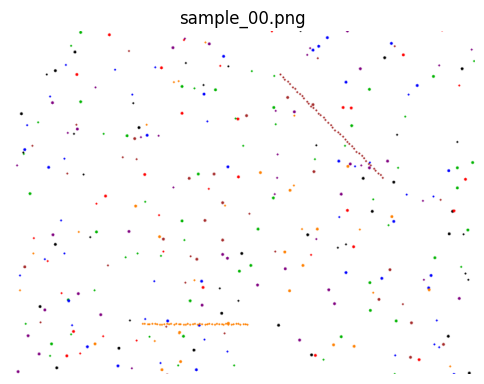

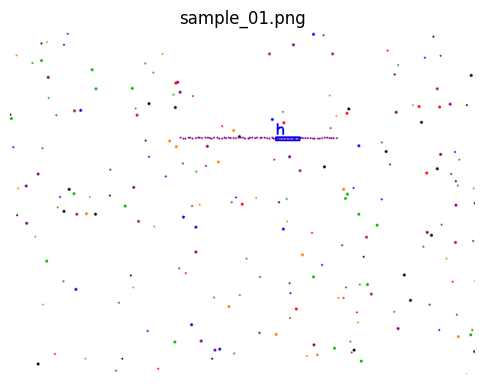

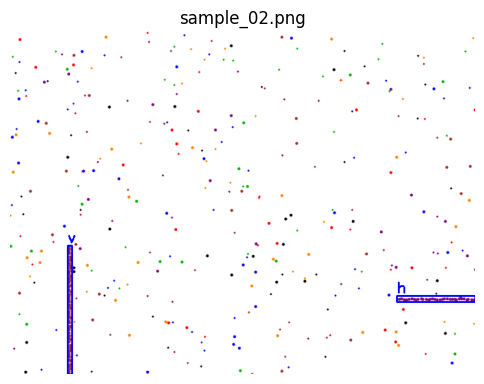

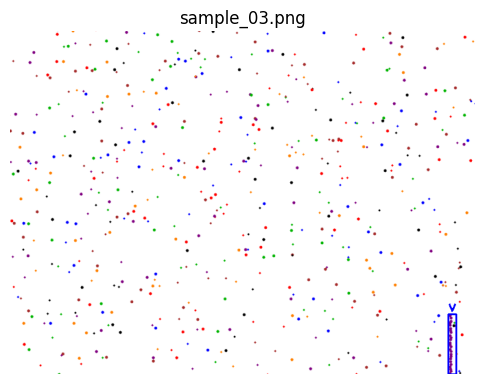

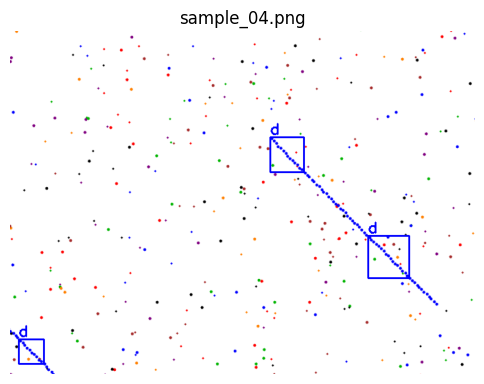

In [4]:
import cv2
from matplotlib import pyplot as plt

for _, row in df.head(5).iterrows():
    img = cv2.imread(row["annotated_path"])
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(row["image_file_name"])
    plt.axis("off")
    plt.show()